# Signal-to-noise Ratio


Here we inject a supernova signal into aLIGO colored noise, and calculate the signal-to-noise ratio (SNR) of the signal. The SNR is a measure of how well the signal stands out from the noise. 


We also compute the SNR using a 'blip'-glitch model for the signal, and compare the two SNR values.

In [ ]:
! pip instal starccato bilby[gw]

In [ ]:
import bilby
import numpy as np
from starccato import generate_signals
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into.
# These are fixed by the resolution in the injection file that we are using.

sampling_frequency = 4096
n_timestamps = 256
duration = n_timestamps / sampling_frequency
time = np.linspace(0, duration, n_timestamps)
t0 = time[53]  # This is the time of the core-bounce

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "supernova"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(170801)

# We are going to inject a supernova waveform.  We first establish a dictionary
# of parameters that includes all of the different waveform parameters. It will
# read in a signal to inject from a txt file.

injection_parameters = dict(
    luminosity_distance=10,  # kpc
    geocent_time=1126259642.413,
    ra=0,
    dec=0,
    psi=0
)


def supernova(time_array, luminosity_distance, **kwargs):
    """
    A source model that reads a simulation from a text file.

    This was originally intended for use with supernova simulations, but can
    be applied to any source class.

    Parameters
    ----------
    frequency_array: array-like
        Unused (but required by the source model interface)
    file_path: str
        Path to the file containing the NR simulation. The format of this file
        should be readable by :code:`numpy.loadtxt` and have four columns
        containing the real and imaginary components of the plus and cross
        polarizations.
    luminosity_distance: float
        The distance to the source in kpc, this scales the amplitude of the
        signal. The simulation is assumed to be at 10kpc.
    kwargs:
        extra keyword arguments, this should include the :code:`file_path`

    Returns
    -------
    dict:
        A dictionary containing the plus and cross components of the signal.
    """

    waveform = generate_signals(n=1, **kwargs)[0]

    # waveforms generated at 10kpc, so scale to the luminosity distance
    scaling = 1e-21 * (10.0 / luminosity_distance)

    # idk if the signal is hcross/hplus, so we just duplicate for now... #TODO
    h_plus = scaling * waveform
    return {'plus': h_plus, 'cross': h_plus}


# Create the waveform_generator using a supernova source function
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=supernova,
    parameters=injection_parameters,
    parameter_conversion=lambda parameters: (parameters, list()),
    waveform_arguments=dict(seed=0),
)

# Set up interferometers (LIGO-Hanford (H1) and LIGO-Livingston (L1))
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"],

)

injection_strain_time = waveform_generator.time_domain_strain(injection_parameters)
injection_strain = waveform_generator.frequency_domain_strain(injection_parameters)

ifos.inject_signal(
    injection_polarizations=injection_strain,
    parameters=injection_parameters,
    raise_error=False,
)


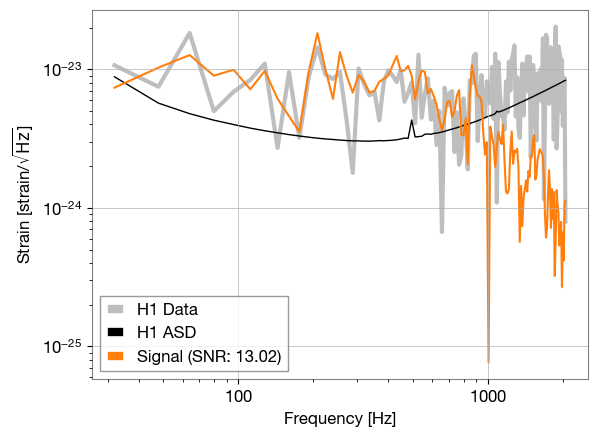

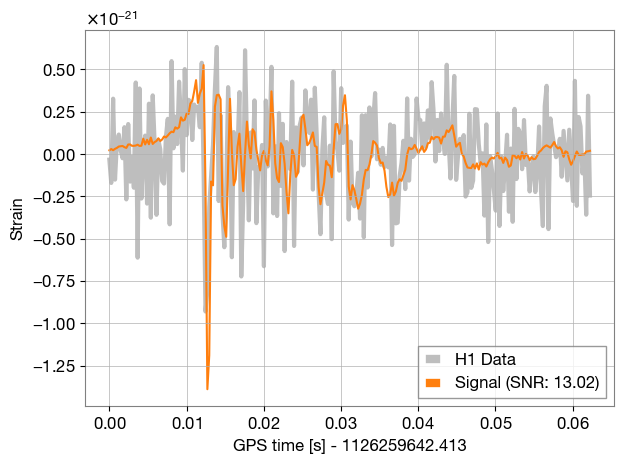

In [68]:
from bilby.gw import utils as gwutils
import matplotlib.pyplot as plt


DATA_COL = 'tab:gray'
SIGNAL_COL = 'tab:orange'
PSD_COL = 'black'

def plot_freq_domain(ifo: bilby.gw.detector.Interferometer, freq_signal):
    fig, ax = plt.subplots()
    df = ifo.strain_data.frequency_array[1] - ifo.strain_data.frequency_array[0]
    asd = gwutils.asd_from_freq_series(
        freq_data=ifo.strain_data.frequency_domain_strain, df=df)

    ax.loglog(ifo.strain_data.frequency_array[ifo.strain_data.frequency_mask],
              asd[ifo.strain_data.frequency_mask],
              color=DATA_COL, label=f"{ifo.name} Data", alpha=0.5, lw=3)
    ax.loglog(ifo.strain_data.frequency_array[ifo.strain_data.frequency_mask],
              ifo.amplitude_spectral_density_array[ifo.strain_data.frequency_mask],
              color=PSD_COL, lw=1.0, label=ifo.name + ' ASD')

    signal_asd = gwutils.asd_from_freq_series(
        freq_data=freq_signal, df=df)

    ax.loglog(ifo.strain_data.frequency_array[ifo.strain_data.frequency_mask],
              signal_asd[ifo.strain_data.frequency_mask],
              color=SIGNAL_COL,
              label=f'Signal (SNR: {ifo.meta_data["optimal_SNR"]:.2f})')
    ax.grid(True)
    ax.set_ylabel(r'Strain [strain/$\sqrt{\rm Hz}$]')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.legend(loc='best')


def plot_time_domain(ifo, time_signal):
    fig, ax = plt.subplots()
    strain = ifo.strain_data.time_domain_strain
    t0 = ifo.strain_data.start_time
    x = ifo.strain_data.time_array - t0
    xlabel = f'GPS time [s] - {t0}'
    # unroll raw data
    strain = np.roll(strain, 55)
    ax.plot(x, strain, color=DATA_COL, label=f"{ifo.name} Data", alpha=0.5, lw=3)
    ax.plot(x, time_signal, color=SIGNAL_COL, label=f'Signal (SNR: {ifo.meta_data["optimal_SNR"]:.2f})')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Strain')
    ax.legend()
    fig.tight_layout()


plot_freq_domain(ifos[0], injection_strain['plus'])
plot_time_domain(ifos[0], injection_strain_time['plus'])